# **Introduction to Deep Learning for Visual Computing (INF01050 and CMP620)**
# **Assignment 1**
<!-- # Name(s): <font color='red'>Ulileh</font><font color='red'>Mariana Risco</font> -->
### 👩‍💻 Name(s): <span style="color:crimson; font-weight:bold;">Ulilé Indeque and Mariana Risco</span>
https://github.com/luisesanlucas/Facemask-detection/blob/main/CNN%20balanced.py


In [2]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet

In [ ]:
#
#  Common header for all students: download and unzip the dataset
#
!wget https://www.inf.ufrgs.br/~crjung/fdl/modified_voc.zip
!unzip modified_voc
!ls -l

From this point on, you should proceed with your solution and discussion

**Exercise 1**

In [4]:
ann = pd.read_csv("annotations.csv")
print(ann.shape)
display(ann.head())
train_path = ann[ann["split"] == "train"]
valid_path  = ann[ann["split"] == "test"]

(1202, 4)


,image,dog,person,split
0,image_0062.jpg,0,0,train
1,image_0238.jpg,0,0,test
2,image_0674.jpg,0,1,train
3,image_0747.jpg,0,1,test
4,image_0252.jpg,0,0,train


In [12]:
def read_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    return img, label

def map_imgs(df):
    paths = df["image"].values
    labels = df[["dog", "person"]].values.astype(np.float32)

    imgset = tf.data.Dataset.from_tensor_slices((paths, labels))
    imgset = imgset.map(
        read_img,
        num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)
    return imgset

img_train = map_imgs(train_path)
img_valid = map_imgs(valid_path)

In [13]:
def print_imgs(batched):
    plt.figure(figsize=(10, 6))
    for img, labels in batched.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(img[i].numpy().astype("uint8"))
            plt.title(labels[i].numpy())
            plt.axis("off")

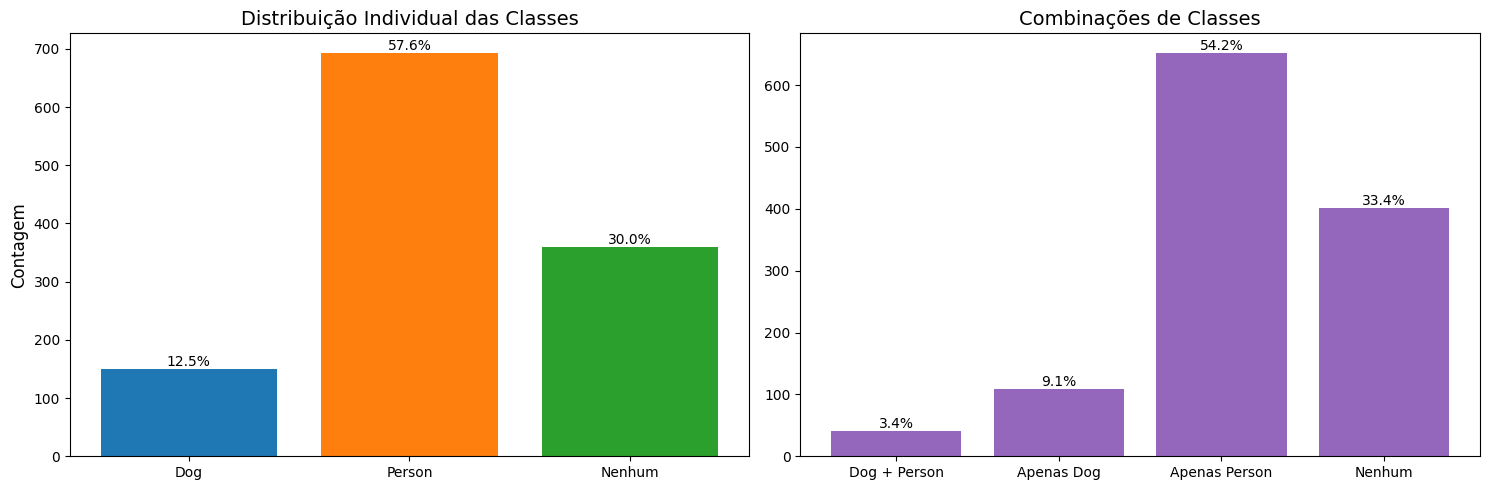

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('annotations.csv')

class_counts = df[['dog', 'person']].sum().sort_values(ascending=False)
combination_counts = df.groupby(['dog', 'person']).size()

plt.figure(figsize=(15, 5))

# Subplot 1: Distribuição Individual
plt.subplot(1, 2, 1)
bars = plt.bar(
    ['Dog', 'Person', 'Nenhum'],
    [class_counts['dog'], class_counts['person'], len(df) - class_counts.sum()],
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
plt.title('Distribuição Individual das Classes', fontsize=14)
plt.ylabel('Contagem', fontsize=12)

total = len(df)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height/total:.1%}',
             ha='center', va='bottom')

# Subplot 2: Combinações de Classes
plt.subplot(1, 2, 2)
comb_labels = [
    'Dog + Person',
    'Apenas Dog',
    'Apenas Person',
    'Nenhum'
]
comb_values = [
    combination_counts.get((1,1), 0),
    combination_counts.get((1,0), 0),
    combination_counts.get((0,1), 0),
    combination_counts.get((0,0), 0)
]

bars = plt.bar(comb_labels, comb_values, color='#9467bd')
plt.title('Combinações de Classes', fontsize=14)

# Adicionar porcentagens
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height/total:.1%}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

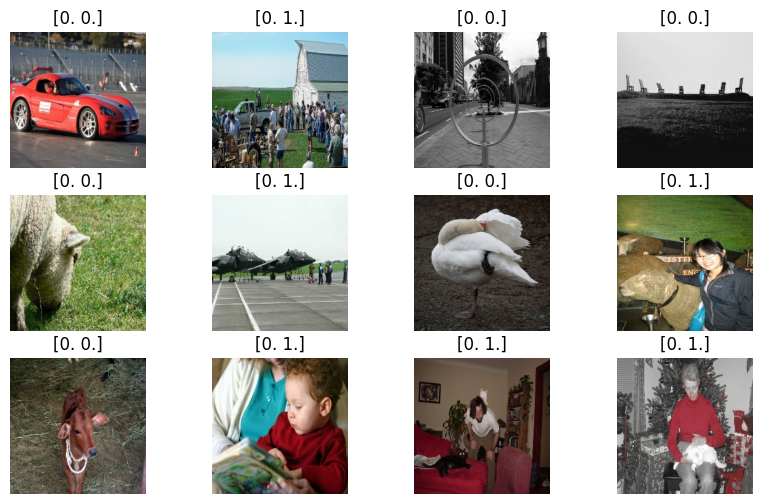

In [ ]:
print_imgs(img_train)

In [10]:
def build_model():
    base_model = keras.applications.MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        name="base_model"
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = keras.applications.mobilenet.preprocess_input(inputs)
    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(2, activation='sigmoid', name="output")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
        ]
    )

    return model
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,322 (12.82 MB)

 Trainable params: 131,458 (513.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [14]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='multilabels_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    img_train,
    epochs=50,
    validation_data=img_valid,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5373 - loss: 0.8315 - precision: 0.4955 - recall: 0.5999  
Epoch 1: val_accuracy improved from -inf to 0.53433, saving model to multilabels_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5374 - loss: 0.8208 - precision: 0.5070 - recall: 0.6009 - val_accuracy: 0.5343 - val_loss: 0.4450 - val_precision: 0.8623 - val_recall: 0.6261 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6041 - loss: 0.4031 - precision: 0.8126 - recall: 0.6572
Epoch 2: val_accuracy improved from 0.53433 to 0.67761, saving model to multilabels_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.6059 - loss: 0.4043 - precision: 0.8074 - recall: 0.6602 - val_accuracy: 0.6776 - val_loss: 0.3395 - val_precision: 0.8534 - val_recall: 0.7087 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6995 - loss: 0.3407 - precision: 0.8485 - recall: 0.7219
Epoch 3: v

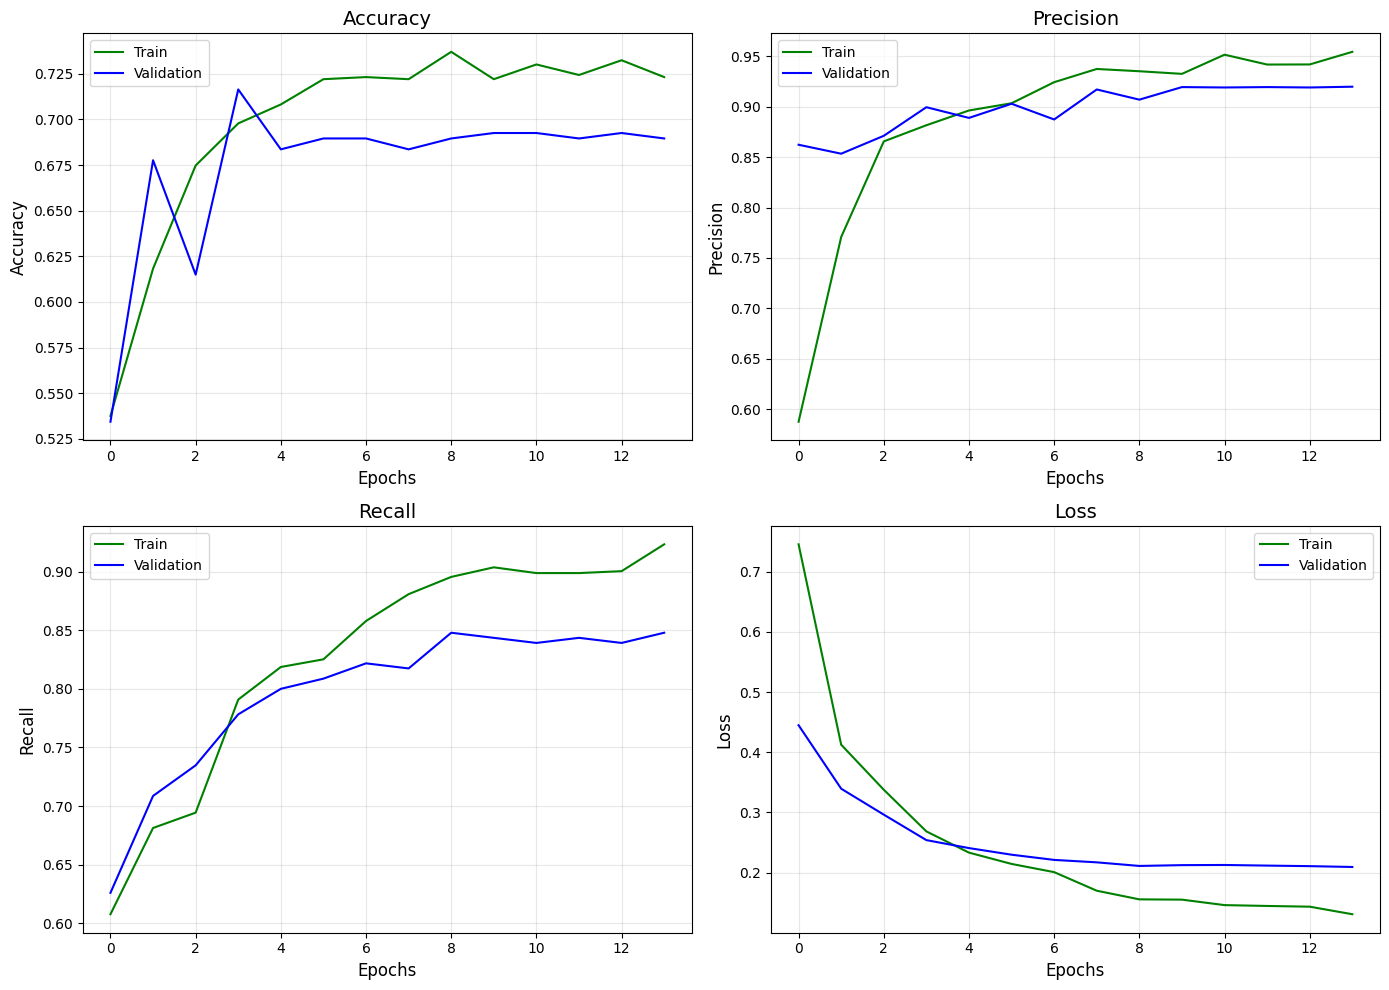

In [15]:
def plot_summary(histories):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.title('Accuracy', fontsize=14)
    plt.plot(histories.history['accuracy'], color='green', label='Train')
    plt.plot(histories.history['val_accuracy'], color='blue', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.title('Precision', fontsize=14)
    plt.plot(histories.history['precision'], color='green', label='Train')
    plt.plot(histories.history['val_precision'], color='blue', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.title('Recall', fontsize=14)
    plt.plot(histories.history['recall'], color='green', label='Train')
    plt.plot(histories.history['val_recall'], color='blue', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 2, 4)
    plt.title('Loss', fontsize=14)
    plt.plot(histories.history['loss'], color='green', label='Train')
    plt.plot(histories.history['val_loss'], color='blue', label='Validation')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_summary(history)

In [1]:
def make_model():
    base_model = keras.applications.MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        name="base_model")

    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2),
        keras.layers.RandomContrast(0.1)
    ])

    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = keras.applications.mobilenet.preprocess_input(x)
    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.7)(x)
    outputs = keras.layers.Dense(2, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(),
            keras.metrics.Recall()]
    )

    base_model.trainable = False
    model.fit(
        train_data,
        epochs=20,
        validation_data=val_data,
        callbacks=callbacks)

    base_model.trainable = True
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(1e-3))
    return model

model = make_model()
model.summary()

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='multilabels_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

histories = model.fit(
    img_train,
    epochs=50,
    validation_data=img_valid,
    callbacks=callbacks
)